In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame


from sqlalchemy import create_engine
engine = create_engine('postgresql://user:@localhost:5432/postgres')
conn = engine.connect()

from geoalchemy2 import Geometry, WKTElement

from sklearn import ensemble, neural_network, preprocessing, model_selection,metrics,pipeline, decomposition, cluster,naive_bayes,gaussian_process

%matplotlib inline


In [3]:
df_nyc_use  = gpd.read_file('Final/Data/df_nyc_use.gpkg',driver='GPKG')
df_natl_use = gpd.read_file('Final/Data/df_natl_use.gpkg',driver='GPKG')
df_all_use2 = gpd.read_file('Final/Data/df_all_use2.geojson')

In [4]:
def stdarize(X):
    std = np.std(X)
    mean = np.mean(X)
    
    return((X-X.mean())/X.std())

# 1. Model UR

## 1.1 Train on NYC data and UR data in other cities

### 1.1.1 Prep data

In [5]:
x_cols1 = [ 'population',
       'white', 'white_perc', 'black', 'black_perc', 'other', 'other_perc','median_homevalue_adj','median_income_adj', 'homes', 'college',
       'college_perc', 'owned_perc', 'population_density','county_pop']

x_cols3 = [ 'dist_to_center','ph_buildings_count','ph_mean_constr_year','ph_total_units_in_tract',
    'population_1940',
       'white_1940', 'white_perc_1940', 'black_1940', 'black_perc_1940', 'other_1940', 'other_perc_1940',
        'median_homevalue_adj_1940', 'homes_1940', 'college_1940',
       'college_perc_1940', 'owned_perc_1940', 'population_density_1940',
       'population_1950', 'white_1950', 'white_perc_1950', 'black_1950',
       'black_perc_1950', 'other_1950', 'other_perc_1950',
        'median_homevalue_adj_1950', 'homes_1950',
       'college_1950', 'college_perc_1950','median_income_1950','median_income_adj_1950', 'owned_perc_1950', 'population_density_1950','Total_units_1950',
       '1940_later_1950', '1930_1939_1950', '1920_1929_1950',
       '1910_earlier_1950', '1940_later_perc_1950', '1930_1939_perc_1950',
       '1920_1929_perc_1950', '1910_earlier_perc_1950',
       'population_1960', 'white_1960', 'white_perc_1960', 'black_1960',
       'black_perc_1960', 'other_1960', 'other_perc_1960',
       'median_homevalue_1960', 'median_homevalue_adj_1960', 'homes_1960',
       'college_1960', 'college_perc_1960', 'median_income_adj_1960',
       'median_income_1960', 'owned_perc_1960', 'population_density_1960',
           'population_1970', 'white_1970', 'white_perc_1970', 'black_1970',
       'black_perc_1970', 'other_1970', 'other_perc_1970',
       'median_homevalue_1970', 'median_homevalue_adj_1970', 'homes_1970',
       'college_1970', 'college_perc_1970', 'median_income_adj_1970',
       'median_income_1970', 'owned_perc_1970', 'population_density_1970',
    'population_1980', 'white_1980', 'white_perc_1980', 'black_1980',
       'black_perc_1980', 'other_1980', 'other_perc_1980',
         'median_homevalue_adj_1980', 'homes_1980',
       'college_1980', 'college_perc_1980', 'median_income_adj_1980','median_income_1980','owned_perc_1980', 'population_density_1980',
    'county_pop_1980','county_pop_1950','county_pop_1940','county_pop_1960','county_pop_1970',
       
]

housing_age_cols = ['Total_units_1950', '1940_later_1950', '1930_1939_1950', '1920_1929_1950',       '1910_earlier_1950', '1940_later_perc_1950', '1930_1939_perc_1950',
       '1920_1929_perc_1950', '1910_earlier_perc_1950',]

### 1.1.2 Select a sample of non-UR areas

In [89]:

X1 = df_all_use2[x_cols3]+.0000000001

## Standardize by State, County
X1 = pd.merge(df_all_use2[['state','county']],X1,right_index=True,left_index=True)

for c in x_cols1: 
    if c =='median_income_adj':
        X1[c+"_1960_diff"] = X1[c+'_1960']-X1[c+'_1950']
        X1[c+"_1970_diff"] = X1[c+'_1970']-X1[c+'_1960']
        X1[c+"_1980_diff"] = X1[c+'_1980']-X1[c+'_1970']
    else: 
        X1[c+"_1950_diff"] = X1[c+'_1950']-X1[c+'_1940']
        X1[c+"_1960_diff"] = X1[c+'_1960']-X1[c+'_1950']
        X1[c+"_1970_diff"] = X1[c+'_1970']-X1[c+'_1960']
        X1[c+"_1980_diff"] = X1[c+'_1980']-X1[c+'_1970']

X1 = X1.groupby(['state','county'])\
        .apply(stdarize)
X1.replace([np.inf, -np.inf], np.nan, inplace=True)
X1 = X1.fillna(.0000000001)
X1 = X1.drop(columns=['state','county'])

## Add in a clustering component
k=10
kmeans = cluster.KMeans(n_clusters=k, init='k-means++')


kmeans.fit_transform(X1)
X1['label_k{}'.format(k)] = kmeans.fit_predict(X1)
X1_dummies= pd.get_dummies(X1['label_k{}'.format(k)],prefix='kmeans')
X1_dummies_cols = X1_dummies.columns
X1 = pd.concat([X1,X1_dummies],axis=1)

## Create a new DF with the dummy vars
df_all_use3 = pd.concat([df_all_use2,X1_dummies,X1['label_k{}'.format(k)]],axis=1)
df_all_use3[['label_k{}'.format(k),'geometry']].to_postgis('tracts_withlabels', engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MultiPolygon', srid= 4326)})

X1 = pd.merge(df_all_use3[['state','county','has_ur','has_ph','nyc']],X1,right_index=True,left_index=True)

# ### Create a sample of the X's that are in NYC or has UR. 
X1_1 =  X1[X1['nyc']=='yes']
X1_2 =  X1[(X1['nyc']=='no')&(X1['has_ur']=='yes')].sample(frac=.6)
X1_3 =  X1[(X1['nyc']=='no')&(X1['has_ur']=='no')].sample(frac=.1,random_state=42)

## Choose the five tracts furthest away from the city center that does not have UR. 
X1_3 = X1[(X1['nyc']=='no')&(X1['has_ur']=='no')].sort_values(['state','county','dist_to_center']).groupby(['state','county'],group_keys=False).tail(5)

X1_use = pd.concat([X1_1,X1_2,X1_3])
# X1 = X1[((X1['state']=='36')&(X1['county'].isin(['005','047','061','081','085'])))|(X1['has_ur']=='yes')]
X1_use= X1_use.drop(columns=['state','county','has_ur','nyc','label_k{}'.format(k)])



# ## modify original data for any new dropped drows
df_all_use4 = df_all_use3.loc[X1_use.index]


In [98]:
df_all_use2.groupby(['state','county']).count()

level_0  gisjoin  index  gisjoin_1930  count  \
state county                                                          
AL    Jefferson             52       52      0             0      0   
CA    Alameda              117      117      0             0      0   
      Contra Costa          13       13      0             0      0   
      Los Angeles          586      586      0             0      0   
      San Francisco        118      118      0             0      0   
...                        ...      ...    ...           ...    ...   
TX    Harris                50       50      0             0      0   
      Travis                14       14      0             0      0   
VA    Richmond (city)       47       47      0             0      0   
WA    King                  79       79      0             0      0   
WI    Milwaukee            153      153      0             0      0   

                       population_1940  white_1940  white_perc_1940  \
state county                                                          
AL    Jefferson                     52          52               52   
CA    Alameda                      117         117              117   
      Contra Costa                  13          13               13   
      Los Angeles                  586         586              586   
      San Francisco                118         118              118   
...                                ...         ...              ...   
TX    Harris                        50          50               50   
      Travis                        14          14               14   
VA    Richmond (city)               47          47               47   
WA    King                          79          79               79   
WI    Milwaukee                    153         153              153   

                       black_1940  black_perc_1940  ...  county_pop_1970  \
state county                                        ...                    
AL    Jefferson                52               52  ...               52   
CA    Alameda                 117              117  ...              117   
      Contra Costa             13               13  ...               13   
      Los Angeles             586              586  ...              586   
      San Francisco           118              118  ...              118   
...                           ...              ...  ...              ...   
TX    Harris                   50               50  ...               50   
      Travis                   14               14  ...               14   
VA    Richmond (city)          47               47  ...               47   
WA    King                     79               79  ...               79   
WI    Milwaukee               153              153  ...              153   

                       STATE_FIPS  COUNTYFIPS  NAME  ph_buildings_count  \
state county                                                              
AL    Jefferson                52          52    52                   8   
CA    Alameda                 117         117   117                   3   
      Contra Costa             13          13    13                   2   
      Los Angeles             586         586   586                  50   
      San Francisco           118         118   118                   4   
...                           ...         ...   ...                 ...   
TX    Harris                   50          50    50                   7   
      Travis                   14          14    14                   1   
VA    Richmond (city)          47          47    47                   8   
WA    King                     79          79    79                  27   
WI    Milwaukee               153         153   153                  64   

                       ph_mean_constr_year  ph_total_units_in_tract  \
state county                                                          
AL    Jefferson                          8                        8 

In [83]:
### Optional: PCA
pca = decomposition.PCA(n_components='mle')
X1_use_pca = pca.fit_transform(X1_use)
X1_use_pca = X1_use_pca[:,:50]

### 1.1.3 Create train test sets

In [84]:
y1 = df_all_use4.loc[X1_use.index]['has_ur']
y1 = np.array(y1)
y1 = [0 if j=='no' else 1 for j in y1]

### Only using diffs in the X's
X1_use = X1_use[['dist_to_center']+\
                list(X1_use.columns[X1_use.columns.str.contains('diff')])+\
                list(X1_use.columns[X1_use.columns.str.contains('kmeans')])+\
                list(X1_use.columns[X1_use.columns.str.contains('ph')])+\
                ['has_ph']+
                housing_age_cols]
X_train1, X_test1, y_train1, y_test1 =model_selection.train_test_split(X1_use, y1)

X_train1_pca, X_test1_pca,y_train1_pca,y_test1_pca  =model_selection.train_test_split(X1_use_pca, y1)

### Create a df just based on the test set for training the model
### and gathering results
df_all_use4 = df_all_use4.loc[X_test1.index]


## 3.3 Get the national tracts
This will essentially create two types of holdout data: 
1) Labeled UR data
2) Non-labeled data, possibly with UR tracts in it.

In [85]:
# df_natl_wnyc_use = pd.concat([df_use,df_natl_use]).copy().reset_index()
# df_rest = df_all_use2.loc[~df_all_use2.index.isin(X1.index)].copy()
df_rest = df_all_use3.copy()


X_natl = X1.loc[~X1.index.isin(X1_use.index)]


X_natl_ur = X_natl[X_natl['has_ur']=='yes']
X_natl_nonur = X_natl[X_natl['has_ur']=='no']

X_natl = X_natl.drop(columns=['state','county','has_ur'])
X_natl_ur = X_natl_ur.drop(columns=['state','county','has_ur'])
X_natl_nonur = X_natl_nonur.drop(columns=['state','county','has_ur'])

#######
## modify original data for any new dropped drows
df_rest1 = df_rest.loc[X_natl.index]
df_rest1_ur = df_rest.loc[X_natl_ur.index]
df_rest1_nonur = df_rest.loc[X_natl_nonur.index]
#######

# y = census_1940_nyc_USE_1.apply(lambda x: 1 if x['has_ur_1960']=='yes' else(2 if x['has_ur_1970']=='yes' else 0) ,axis=1)
y_natl = df_rest1.loc[X_natl.index]['has_ur']
y_natl = [0 if j=='no' else 1 for j in y_natl]

y_natl_ur = df_rest1_ur.loc[X_natl_ur.index]['has_ur']
y_natl_ur = [0 if j=='no' else 1 for j in y_natl_ur]

y_natl_nonur = df_rest1_nonur.loc[X_natl_nonur.index]['has_ur']
y_natl_nonur = [0 if j=='no' else 1 for j in y_natl_nonur]

X_natl = X_natl[['dist_to_center']+\
                list(X_natl.columns[X_natl.columns.str.contains('diff')])+\
                list(X_natl.columns[X_natl.columns.str.contains('kmeans')])+\
                list(X_natl.columns[X_natl.columns.str.contains('ph')])+\
                ['has_ph']+
                housing_age_cols]
X_natl_ur = X_natl_ur[['dist_to_center']+\
                      list(X_natl_ur.columns[X_natl_ur.columns.str.contains('diff')])+\
                      list(X_natl_ur.columns[X_natl_ur.columns.str.contains('kmeans')])+\
                      list(X_natl_ur.columns[X_natl_ur.columns.str.contains('ph')])+\
                      ['has_ph']+
                      housing_age_cols]
X_natl_nonur = X_natl_nonur[['dist_to_center']+\
                        list(X_natl_nonur.columns[X_natl_nonur.columns.str.contains('diff')])+\
                        list(X_natl_nonur.columns[X_natl_nonur.columns.str.contains('kmeans')])+\
                        list(X_natl_nonur.columns[X_natl_nonur.columns.str.contains('ph')])+\
                            ['has_ph']+
                            housing_age_cols]


**Function to automatically update predictions and export geojsons**

In [86]:
def update_export_preds(model,suffix=''):
    print(model)
    df_all_use4['y_pred'] =model.predict(X_test1)
    df_all_use4['y_prob_0'] = model.predict_proba(X_test1)[:,0]
    df_all_use4['y_prob_1'] = model.predict_proba(X_test1)[:,1]

    df_rest1['y_pred'] =model.predict(X_natl)
    df_rest1['y_prob_0'] = model.predict_proba(X_natl)[:,0]
    df_rest1['y_prob_1'] = model.predict_proba(X_natl)[:,1]
    
    df_rest1_ur['y_pred'] =model.predict(X_natl_ur)
    df_rest1_ur['y_prob_0'] = model.predict_proba(X_natl_ur)[:,0]
    df_rest1_ur['y_prob_1'] = model.predict_proba(X_natl_ur)[:,1]
    
    df_rest1_nonur['y_pred'] =model.predict(X_natl_nonur)
    df_rest1_nonur['y_prob_0'] = model.predict_proba(X_natl_nonur)[:,0]
    df_rest1_nonur['y_prob_1'] = model.predict_proba(X_natl_nonur)[:,1]
    
    df_all_use4[['geom','y_pred','y_prob_0','y_prob_1']+\
                list(X1.columns[X1.columns.str.contains('kmeans')])].to_postgis('test_{}'.format(suffix), engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MultiPolygon', srid= 4326)})

    df_rest1[['geom','y_pred','y_prob_0','y_prob_1']].to_postgis('pred_{}'.format(suffix), engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MultiPolygon', srid= 4326)})
    
    df_rest1_ur[['geom','y_pred','y_prob_0','y_prob_1']].to_postgis('pred_UR_{}'.format(suffix), engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MultiPolygon', srid= 4326)})
    
    df_rest1_nonur[['geom','y_pred','y_prob_0','y_prob_1']].to_postgis('pred_nonUR_{}'.format(suffix), engine, if_exists='replace', index=False, 
                         dtype={'geom': Geometry('MultiPolygon', srid= 4326)})
    
    print("Export Done")

## 1.2 Check OLS and lasso regression results


In [91]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train1,y_train1)
print(model.score(X_test1,y_test1))

In [70]:
y_pred1 = model.predict(X_test1)
df_all_use4['y_pred'] =y_pred1

y_prob1 = model.predict_proba(X_test1)
df_all_use4['y_prob_0'] = model.predict_proba(X_test1)[:,0]
df_all_use4['y_prob_1'] = model.predict_proba(X_test1)[:,1]

# sample_weights1 = [1 if x==0 else 10 for x in y_test1]
precision1, recall1, _ = metrics.precision_recall_curve(y_test1,y_pred1)
accuracy1 = metrics.accuracy_score(y_test1,y_pred1)
f11 = metrics.f1_score(y_test1,y_pred1,average='weighted',)
print("Test Set Scores:\n","Precision:",np.round(precision1[1],2),
        "\nRecall:",np.round(recall1[1],2),"\nAccuracy:",np.round(accuracy1,2),"\nF1 weighted:",np.round(f11,2))

# sample_weights1 = [1 if x==0 else 100 for x in y_test1]
# metrics.f1_score(y_test1,y_pred1,average='weighted',sample_weight=sample_weights1)y_pred2 =rf_mdl_estimators.predict(X_natl)
y_pred2 =model.predict(X_natl)
df_rest1['y_pred'] =y_pred2
df_rest1['y_prob_0'] = model.predict_proba(X_natl)[:,0]
df_rest1['y_prob_1'] = model.predict_proba(X_natl)[:,1]

y_pred2_ur =model.predict(X_natl_ur)
df_rest1_ur['y_pred'] =model.predict(X_natl_ur)
df_rest1_ur['y_prob_0'] = model.predict_proba(X_natl_ur)[:,0]
df_rest1_ur['y_prob_1'] = model.predict_proba(X_natl_ur)[:,1]

df_rest1_nonur['y_pred'] =model.predict(X_natl_nonur)
df_rest1_nonur['y_prob_0'] = model.predict_proba(X_natl_nonur)[:,0]
df_rest1_nonur['y_prob_1'] = model.predict_proba(X_natl_nonur)[:,1]

y_pred2_nonur =model.predict(X_natl_nonur)
prop_nonur_pred = np.sum(y_pred2_nonur)/len(y_pred2_nonur)

precision2, recall2, _ = metrics.precision_recall_curve(y_natl, y_pred2)
accuracy2 = metrics.accuracy_score(y_natl,y_pred2)

f12 = metrics.f1_score(y_natl,y_pred2,average='weighted',)
print("National Scores:\n","Precision:",np.round(precision2[1],2),
        "\nRecall:",np.round(recall2[1],2),"\nAccuracy:",np.round(accuracy2,2),"\nF1 weighted:",np.round(f12,2))


precision2_ur, recall2_ur, _ = metrics.precision_recall_curve(y_natl_ur, y_pred2_ur)
accuracy2_ur = metrics.accuracy_score(y_natl_ur,y_pred2_ur)

f12_ur = metrics.f1_score(y_natl_ur,y_pred2_ur,average='weighted',)
print("National UR Scores:\n","Precision:",np.round(precision2_ur[1],2),
        "\nRecall:",np.round(recall2_ur[1],2),"\nAccuracy:",np.round(accuracy2_ur,2),"\nF1 weighted:",np.round(f12_ur,2))

print(f'Proportion Predicted As UR from non-UR sample: {prop_nonur_pred}')

Test Set Scores:
 Precision: 0.74 
Recall: 0.47 
Accuracy: 0.9 
F1 weighted: 0.89
National Scores:
 Precision: 0.16 
Recall: 0.55 
Accuracy: 0.84 
F1 weighted: 0.88
National UR Scores:
 Precision: 1.0 
Recall: 0.55 
Accuracy: 0.55 
F1 weighted: 0.71
Proportion Predicted As UR from non-UR sample: 0.14437367303609341


## 1.3 ML - Hyper-parameter tuning

Since we are not sure about the unlabeled data, we'll test this in two steps: 
- Step 1: Test for just the labeled UR test areas (1's) to get high F1-scores. 
- Step 2: If step 1 is good, test for the unlabeled tracts. This should produce some areas that are labeled 1...percentage TBD.

Function for updating predictions and exporting geoms

### 3.3.1 Random forest 
First test for how to weigh classes

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt',]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,10]
# Method of selecting samples for training each tree
bootstrap = [ False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_mdl = ensemble.RandomForestClassifier(random_state=42,)

rf_random = model_selection.RandomizedSearchCV(estimator = rf_mdl,scoring='f1_weighted', param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train1,y_train1)

In [ ]:
# rf_random.best_params_

In [ ]:
# rf_best = rf_random.best_estimator_
# update_export_preds(rf_best,'rf')

In [ ]:
# rf_mdl_weights =ensemble.RandomForestClassifier(**rf_random.best_params_)
# rf_mdl_weights.fit(X_train1,y_train1)

Which were the best params? Results from running the above:
```
{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 47,
 'bootstrap': False}
 ```

### Create a function to tune the model

In [60]:
def tune_model(mdl,xarray,param_name,**params):
    test_scores = []
    holdout_natl = []
    holdout_natl_ur = []
    prop_nonur_pred = []

    for j in xarray: 
        params[param_name]=j
        print(j)

        ### Train the model
        model = mdl(**params)
#         model.fit(X1_use,y1)
        model.fit(X_train1,y_train1)


#         ## Get the scores for the test set
#         y_pred1 = model.predict(X_test1)

#         ## Get the scores for the national test set
        y_pred2 =model.predict(X_natl)
        y_pred2_ur =model.predict(X_natl_ur)
        model.fit(X_train1,y_train1)
        y_pred2_nonur =model.predict(X_natl_nonur)

        ## Plot the scores' sensitivities. 
        test_scores.append(np.round(np.mean(model_selection.cross_val_score(estimator=model,
                                          X=X1_use,
                                          y=y1,
                                          cv=3,
                                          scoring='f1_weighted')),decimals=3))

#         test_scores.append(np.round(metrics.f1_score(y_test1,y_pred1,average='weighted'),decimals=3))
        holdout_natl.append(np.round(metrics.f1_score(y_natl,y_pred2,average='weighted'),decimals=3))
        holdout_natl_ur.append(np.round(metrics.f1_score(y_natl_ur,y_pred2_ur,average='weighted'),decimals=3))

        prop_nonur_pred.append(np.sum(y_pred2_nonur)/len(y_pred2_nonur))
    
    y_pred1 = model.predict(X_test1)
    df_all_use4['y_pred'] =y_pred1

    y_prob1 = model.predict_proba(X_test1)
    df_all_use4['y_prob_0'] = model.predict_proba(X_test1)[:,0]
    df_all_use4['y_prob_1'] = model.predict_proba(X_test1)[:,1]

    # sample_weights1 = [1 if x==0 else 10 for x in y_test1]
    precision1, recall1, _ = metrics.precision_recall_curve(y_test1,y_pred1)
    accuracy1 = metrics.accuracy_score(y_test1,y_pred1)
    f11 = metrics.f1_score(y_test1,y_pred1,average='weighted',)
    print("Test Set Scores:\n","Precision:",np.round(precision1[1],2),
          "\nRecall:",np.round(recall1[1],2),"\nAccuracy:",np.round(accuracy1,2),"\nF1 weighted:",np.round(f11,2))

    # sample_weights1 = [1 if x==0 else 100 for x in y_test1]
    # metrics.f1_score(y_test1,y_pred1,average='weighted',sample_weight=sample_weights1)y_pred2 =rf_mdl_estimators.predict(X_natl)
    y_pred2 =model.predict(X_natl)
    df_rest1['y_pred'] =y_pred2
    df_rest1['y_prob_0'] = model.predict_proba(X_natl)[:,0]
    df_rest1['y_prob_1'] = model.predict_proba(X_natl)[:,1]

    y_pred2_ur =model.predict(X_natl_ur)
    df_rest1_ur['y_pred'] =model.predict(X_natl_ur)
    df_rest1_ur['y_prob_0'] = model.predict_proba(X_natl_ur)[:,0]
    df_rest1_ur['y_prob_1'] = model.predict_proba(X_natl_ur)[:,1]


    precision2, recall2, _ = metrics.precision_recall_curve(y_natl, y_pred2)
    accuracy2 = metrics.accuracy_score(y_natl,y_pred2)

    f12 = metrics.f1_score(y_natl,y_pred2,average='weighted',)
    print("National Scores:\n","Precision:",np.round(precision2[1],2),
          "\nRecall:",np.round(recall2[1],2),"\nAccuracy:",np.round(accuracy2,2),"\nF1 weighted:",np.round(f12,2))


    precision2_ur, recall2_ur, _ = metrics.precision_recall_curve(y_natl_ur, y_pred2_ur)
    accuracy2_ur = metrics.accuracy_score(y_natl_ur,y_pred2_ur)

    f12_ur = metrics.f1_score(y_natl_ur,y_pred2_ur,average='weighted',)
    print("National UR Scores:\n","Precision:",np.round(precision2_ur[1],2),
          "\nRecall:",np.round(recall2_ur[1],2),"\nAccuracy:",np.round(accuracy2_ur,2),"\nF1 weighted:",np.round(f12_ur,2))
    
    plt.plot(xarray,test_scores,label='Sample')
    plt.plot(xarray,holdout_natl_ur,label='National')
    plt.plot(xarray,prop_nonur_pred,label='Proportion Predicted As UR from non-UR sample')
    plt.legend()
    
    return test_scores,holdout_natl,holdout_natl_ur,prop_nonur_pred

**Number of Estimators**

2
12
22
33
43
54
64
74
85
95
106
116
127
137
147
158
168
179
189
200
Test Set Scores:
 Precision: 0.89 
Recall: 0.72 
Accuracy: 0.95 
F1 weighted: 0.95
National Scores:
 Precision: 0.07 
Recall: 0.93 
Accuracy: 0.4 
F1 weighted: 0.52
National UR Scores:
 Precision: 1.0 
Recall: 0.93 
Accuracy: 0.93 
F1 weighted: 0.96


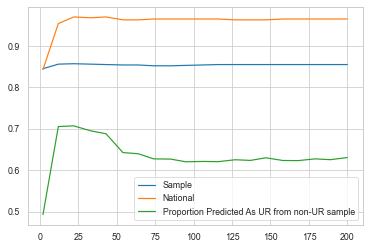

In [ ]:
x_nest = [int(x) for x in np.linspace(2,200,20)]
mdl_params = {
#      'n_estimators': 800,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
 'max_features': 'sqrt',
#  'max_depth': 47,
 'bootstrap': False,
 'random_state':42
}
rf_mdl_nest = ensemble.RandomForestClassifier
test_scores_nest,holdout_natl_nest,holdout_natl_ur_nest,prop_nonur_pred_nest = tune_model(rf_mdl_nest,x_nest,'n_estimators',**mdl_params)

100
144
188
233
277
322
366
411
455
500
Test Set Scores:
 Precision: 0.88 
Recall: 0.77 
Accuracy: 0.95 
F1 weighted: 0.95
National Scores:
 Precision: 0.07 
Recall: 0.95 
Accuracy: 0.36 
F1 weighted: 0.48
National UR Scores:
 Precision: 1.0 
Recall: 0.95 
Accuracy: 0.95 
F1 weighted: 0.97


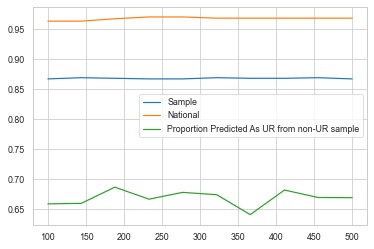

In [ ]:
x_nest = [int(x) for x in np.linspace(100,500,10)]
mdl_params = {
#      'n_estimators': 800,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 47,
#  'bootstrap': False,
#  'random_state':42
}
rf_mdl_nest = ensemble.RandomForestClassifier
test_scores_nest,holdout_natl_nest,holdout_natl_ur_nest,prop_ur_pred_nest = tune_model(rf_mdl_nest,x_nest,'n_estimators',**mdl_params)

In [ ]:
# n_estimators_rf = 200
n_estimators_rf = 100

**Min Samples Leaf**

2
24
46
68
90
112
134
156
178
200
Test Set Scores:
 Precision: 0.91 
Recall: 0.63 
Accuracy: 0.94 
F1 weighted: 0.94
National Scores:
 Precision: 0.08 
Recall: 0.82 
Accuracy: 0.51 
F1 weighted: 0.63
National UR Scores:
 Precision: 1.0 
Recall: 0.82 
Accuracy: 0.82 
F1 weighted: 0.9


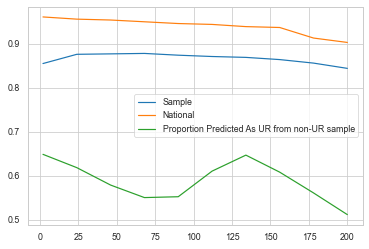

In [ ]:
x_minleaf = [int(x) for x in np.linspace(2,200,10)]
mdl_params = {
    'n_estimators':n_estimators_rf,
#  'min_samples_split': 5,
 'max_features': 'sqrt',
#  'max_depth': None,
 'bootstrap': False,
'random_state':42
}
rf_mdl_minleaf = ensemble.RandomForestClassifier
test_scores_minleaf,holdout_natl_minleaf,holdout_natl_ur_minleaf,prop_ur_pred_minleaf = tune_model(rf_mdl_minleaf,x_minleaf,'min_samples_leaf',**mdl_params)

In [ ]:
# min_samples_leaf_rf=170
min_samples_leaf_rf=60

**Max depth**

2
3
4
5
6
7
8
9
10
Test Set Scores:
 Precision: 0.87 
Recall: 0.72 
Accuracy: 0.95 
F1 weighted: 0.94
National Scores:
 Precision: 0.08 
Recall: 0.91 
Accuracy: 0.44 
F1 weighted: 0.57
National UR Scores:
 Precision: 1.0 
Recall: 0.91 
Accuracy: 0.91 
F1 weighted: 0.96


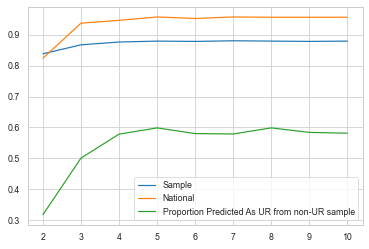

In [ ]:
x_maxdepth = [int(x) for x in np.linspace(2,10,9)]
mdl_params = {
    'n_estimators':n_estimators_rf,
 'min_samples_leaf':min_samples_leaf_rf,
 'max_features': 'sqrt',
 'bootstrap': False,
'random_state':42
}
rf_mdl_maxdepth = ensemble.RandomForestClassifier
test_scores_maxdepth,holdout_natl_maxdepth,holdout_natl_ur_maxdepth,prop_ur_pred_maxdepth = tune_model(rf_mdl_maxdepth,x_maxdepth,'max_depth',**mdl_params)

In [ ]:
max_depth_rf =3
# max_depth_rf =8

**Min samples split**

2
26
51
75
100
Test Set Scores:
 Precision: 0.84 
Recall: 0.58 
Accuracy: 0.93 
F1 weighted: 0.92
National Scores:
 Precision: 0.1 
Recall: 0.7 
Accuracy: 0.68 
F1 weighted: 0.77
National UR Scores:
 Precision: 1.0 
Recall: 0.7 
Accuracy: 0.7 
F1 weighted: 0.82


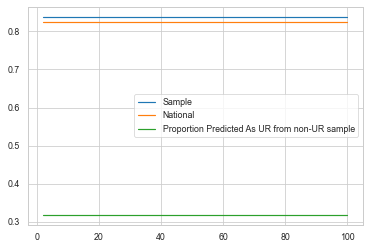

In [ ]:
x_split = [int(x) for x in np.linspace(2,100,5)]
mdl_params = {
    'n_estimators':n_estimators_rf,
 'min_samples_leaf':min_samples_leaf_rf,
 'max_features': 'sqrt',
    'max_depth':max_depth_rf,
 'bootstrap': False,
'random_state':42}
rf_mdl_split = ensemble.RandomForestClassifier
test_scores_split,holdout_natl_split,holdout_natl_ur_split,prop_ur_pred_split = tune_model(rf_mdl_split,x_split,'min_samples_split',**mdl_params)

In [ ]:
min_samples_split_rf= 40

## Final RF Model
```
mdl_params_final = {
    'n_estimators':200,
 'min_samples_leaf': 200,
    'min_samples_split':2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}
 ```

In [ ]:
mdl_params_final = {
    'n_estimators':n_estimators_rf,
 'min_samples_leaf': min_samples_leaf_rf,
    'min_samples_split':min_samples_split_rf,
 'max_features': 'sqrt',
 'max_depth': max_depth_rf,
 'bootstrap': False}
rf_mdl_final = ensemble.RandomForestClassifier(**mdl_params_final)

rf_mdl_final.fit(X_train1,y_train1)

df_all_use4['y_pred'] =rf_mdl_final.predict(X_test1)
print(df_all_use4['y_pred'].sum()/np.sum(y_test1))

# df_rest1_ur['y_prob_1'] = model.predict_proba(X_natl_ur)[:,1]

df_rest1_nonur['y_pred'] =rf_mdl_final.predict(X_natl_nonur)
df_rest1_nonur['y_prob_0'] = rf_mdl_final.predict_proba(X_natl_nonur)[:,0]
df_rest1_nonur['y_prob_1'] = rf_mdl_final.predict_proba(X_natl_nonur)[:,1]
print(df_rest1_nonur['y_pred'].sum()/df_rest1_nonur['y_pred'].shape[0])

update_export_preds(rf_mdl_final,'rf6')

0.7846153846153846
0.486553432413305
RandomForestClassifier(bootstrap=False, max_depth=3, max_features='sqrt',
                       min_samples_leaf=60, min_samples_split=40)
Export Done


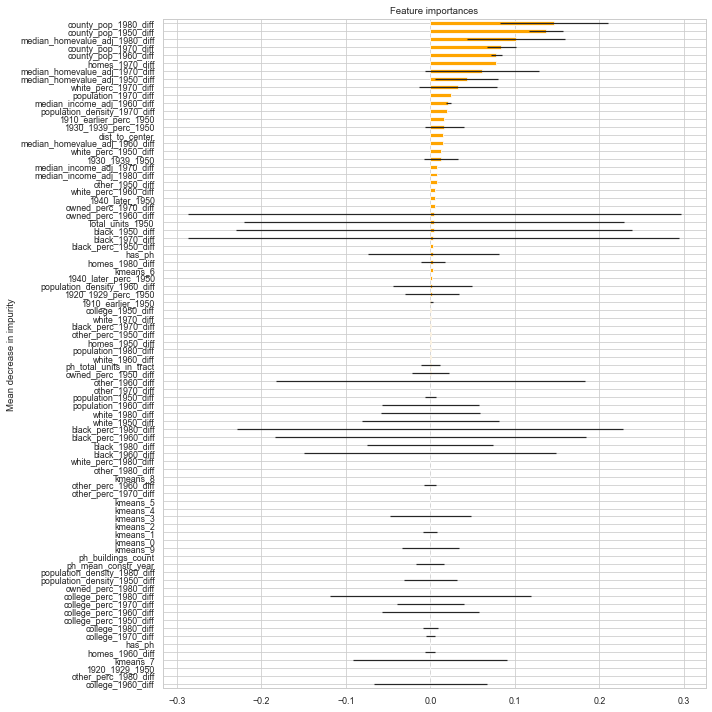

In [ ]:


importances = rf_mdl_final.feature_importances_
forest_importances = pd.Series(importances, index=X_train1.columns).sort_values()
std = np.std([
    tree.feature_importances_ for tree in rf_mdl_final.estimators_], axis=0)


fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.barh(xerr=std, ax=ax,color='orange')
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# plt.savefig('Results/ur_modeling_importances_rf.svg')

### 3.3.2 Now try the MLP
Best estimator based on previous run

```
MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 100), max_iter=3933,
              random_state=42, solver='sgd'
```

In [90]:
# L2 Loss
alpha = np.linspace(start = 0.00001, stop = 0.001, num = 5)
# Hidden layers
hidden_layer_sizes = [(10,),(50,),(100,),(500,)]
## Solver
# solver= ['lbfgs', 'sgd', 'adam']
solver= ['sgd']
## Warm Start
# warm_start = [True,False]
warm_start = [True]
## Max iterations
max_iter = [int(x) for x in np.linspace(start = 100, stop =5000, num = 10)]

# Create the random grid
random_grid = {'alpha': alpha,
               'hidden_layer_sizes': hidden_layer_sizes,
               'solver': solver,
               'warm_start': warm_start,
               'max_iter': max_iter}

nn_mdl = neural_network.MLPClassifier(random_state=42)

nn_random = model_selection.RandomizedSearchCV(estimator = nn_mdl,scoring='f1_weighted', param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
nn_random.fit(X_train1,y_train1)

In [ ]:
# nn_best = nn_random.best_estimator_

In [ ]:
# nn_random.best_estimator_

MLPClassifier(alpha=0.0002575, max_iter=644, random_state=42, solver='sgd',
              warm_start=True)

In [ ]:
nn_random.best_estimator_


MLPClassifier(alpha=0.0002575, max_iter=644, random_state=42, solver='sgd',
              warm_start=True)

**Tune the hidden layers**

In [88]:
# x_layers = np.linspace(40,100,4)
# x_layers1=[]

# for i in x_layers:
#     x_layers1.append((int(i),int(i)))
        
# mdl_params = {
# #    'alpha':0.0002575, 
# #     'max_iter':50, 
 
#     'solver':'sgd',
#     'warm_start':False,
#     'random_state':42,}
# nn_mdl_hlayers = neural_network.MLPClassifier
# test_scores_hlayers,holdout_natl_hlayers,holdout_natl_ur_hlayers,prop_ur_pred_hlayers = tune_model(nn_mdl_hlayers,x_layers1,'hidden_layer_sizes',**mdl_params)

In [ ]:
# x_layers = np.linspace(10,100,4)
# x_layers1=[]

# for i in x_layers:
#     x_layers1.append((int(i),))
        
# mdl_params = {
# #    'alpha':0.0002575, 
# #     'max_iter':50, 
 
#     'solver':'sgd',
#     'warm_start':False,
#     'random_state':42,}
# nn_mdl_hlayers = neural_network.MLPClassifier
# test_scores_hlayers,holdout_natl_hlayers,holdout_natl_ur_hlayers,prop_ur_pred_hlayers = tune_model(nn_mdl_hlayers,x_layers1,'hidden_layer_sizes',**mdl_params)

In [ ]:
x_layers = np.linspace(10,80,4)
x_layers1=[]

for i in x_layers:
    x_layers1.append((int(i),int(i),int(i)))
        
mdl_params = {
#    'alpha':0.0002575, 
#     'max_iter':50, 
 
    'solver':'sgd',
    'warm_start':False,
    'random_state':42,}
nn_mdl_hlayers = neural_network.MLPClassifier
test_scores_hlayers,holdout_natl_hlayers,holdout_natl_ur_hlayers,prop_ur_pred_hlayers = tune_model(nn_mdl_hlayers,x_layers1,'hidden_layer_sizes',**mdl_params)

In [ ]:
# hidden_layer_sizes_nn = (70,70,70)
hidden_layer_sizes_nn = (100)
# hidden_layer_sizes_nn = (100,100)

**Max iter**

In [81]:
x_iter = [int(x) for x in np.linspace(100,1000,8)]
mdl_params = {     
#     'max_iter':max_iter_nn,
#     'alpha':alpha_nn,
     'hidden_layer_sizes':hidden_layer_sizes_nn,
    'solver':'sgd',
    'warm_start':False,
             'random_state':42,}
# mdl_params = {
# #    'alpha':0.0002575, 
# #     'max_iter':50, 
#      'hidden_layer_sizes':hidden_layer_sizes_nn,
#     'solver':'sgd',
#     'warm_start':False,
#     'random_state':42,}
nn_mdl_iter = neural_network.MLPClassifier
test_scores_iter,holdout_natl_iter,holdout_natl_ur_iter,prop_ur_pred_iter = tune_model(nn_mdl_iter,x_iter,'max_iter',**mdl_params)

In [ ]:
max_iter_nn = 600

**L2 Penalty**

In [ ]:
x_alpha = np.linspace(0.0001,2,10)

        
mdl_params = {
    'max_iter':max_iter_nn,
     'hidden_layer_sizes':hidden_layer_sizes_nn,
    'solver':'sgd',
    'warm_start':False,
    'random_state':42,
}
nn_mdl_alpha = neural_network.MLPClassifier
test_scores_alpha,holdout_natl_alpha,holdout_natl_ur_alpha,prop_ur_pred_alpha = tune_model(nn_mdl_alpha,x_alpha,'alpha',**mdl_params)


In [ ]:
x_alpha = np.linspace(2,15,9)

        
mdl_params = {
     'max_iter':max_iter_nn,
     'hidden_layer_sizes':hidden_layer_sizes_nn,
    'solver':'sgd',
    'warm_start':False,
    'random_state':42,}
nn_mdl_alpha = neural_network.MLPClassifier
test_scores_alpha,holdout_natl_alpha,holdout_natl_ur_alpha,prop_ur_pred_alpha = tune_model(nn_mdl_alpha,x_alpha,'alpha',**mdl_params)


In [ ]:
hidden_layer_sizes_nn = (20,20,20,20)

In [ ]:
alpha_nn = 4

In [ ]:
mdl_params = {
     'max_iter':max_iter_nn,
    'alpha':alpha_nn,
     'hidden_layer_sizes':hidden_layer_sizes_nn,
    'solver':'sgd',
    'warm_start':False,
    'random_state':42,
}
nn_mdl_final = neural_network.MLPClassifier(**mdl_params)
nn_mdl_final.fit(X_train1,y_train1)

df_all_use4['y_pred'] =nn_mdl_final.predict(X_test1)
print(df_all_use4['y_pred'].sum()/np.sum(y_test1))

df_rest1_nonur['y_pred'] =nn_mdl_final.predict(X_natl_nonur)
df_rest1_nonur['y_prob_0'] = nn_mdl_final.predict_proba(X_natl_nonur)[:,0]
df_rest1_nonur['y_prob_1'] = nn_mdl_final.predict_proba(X_natl_nonur)[:,1]
print(df_rest1_nonur['y_pred'].sum()/df_rest1_nonur['y_pred'].shape[0])

update_export_preds(nn_mdl_final,'nn6')

0.6230769230769231
0.32873319179051663
MLPClassifier(alpha=4, hidden_layer_sizes=(20, 20, 20, 20), max_iter=600,
              random_state=42, solver='sgd')
Export Done


### 3.3.3 Now try the GBC

In [ ]:
# Loss
loss = ['deviance']

# Learning Rate
learning_rate = np.linspace(.01,.3,10)

## Number of Estimators
n_estimators = [int(x) for x in np.linspace(50,1000,10)]

## Criterion to measure quality of the split
criterion = ['friedman_mse']

## Min number of samples
min_samples_split = [int(x) for x in np.linspace(2,100,10)]

## Min samples in each leaf
min_samples_leaf = [int(x) for x in np.linspace(2,100,10)]

## Max depth
max_depth = [int(x) for x in np.linspace(2,100,10)]

# Create the random grid
random_grid = {'loss': loss,
               'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'criterion': criterion,
               'min_samples_split': min_samples_split,
               'min_samples_leaf':min_samples_leaf,
              'max_depth':max_depth}

gb_mdl = ensemble.GradientBoostingClassifier(random_state=42,)

gb_random = model_selection.RandomizedSearchCV(estimator = gb_mdl,scoring='f1_weighted', param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train1,y_train1)

In [ ]:
gb_best = gb_random.best_estimator_

In [ ]:
gb_random.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_depth=34,
                           min_samples_leaf=89, min_samples_split=100,
                           n_estimators=50, random_state=42)

```
{'n_estimators': 50,
 'min_samples_split': 100,
 'min_samples_leaf': 89,
 'max_depth': 34,
 'loss': 'deviance',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}
 ```

In [ ]:
gb_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 100,
 'min_samples_leaf': 89,
 'max_depth': 34,
 'loss': 'deviance',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

In [ ]:
best_params_gb = {'n_estimators': 50,
 'min_samples_split': 100,
 'min_samples_leaf': 89,
 'max_depth': 34,
 'loss': 'deviance',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}
gb_mdl = ensemble.GradientBoostingClassifier(**best_params_gb) 
# gb_mdl = ensemble.GradientBoostingClassifier() 
gb_mdl.fit(X_train1,y_train1)

GradientBoostingClassifier(learning_rate=0.01, max_depth=34,
                           min_samples_leaf=89, min_samples_split=100,
                           n_estimators=50)

**Tune n estimators**


10
64
118
173
227
282
336
391
445
500
Test Set Scores:
 Precision: 0.86 
Recall: 0.81 
Accuracy: 0.95 
F1 weighted: 0.95
National Scores:
 Precision: 0.06 
Recall: 0.91 
Accuracy: 0.26 
F1 weighted: 0.36
National UR Scores:
 Precision: 1.0 
Recall: 0.91 
Accuracy: 0.91 
F1 weighted: 0.96


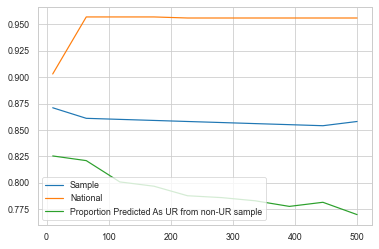

In [ ]:
x_nest= [int(x) for x in np.linspace(10,500,10)]
        
mdl_params = {
#     'n_estimators': 50,
#  'min_samples_split': 100,
#     'min_samples_leaf':8,
#  'max_depth': 34,
 'loss': 'deviance',
#  'learning_rate': learning_rate_gb,
 'criterion': 'friedman_mse'
}
gb_mdl_nest = ensemble.GradientBoostingClassifier
test_scores_x_nest,holdout_natl_x_nest,holdout_natl_ur_x_nest,prop_ur_pred_x_nest = tune_model(gb_mdl_nest,x_nest,'n_estimators',**mdl_params)

2
15
28
41
54
67
80
93
106
120
Test Set Scores:
 Precision: 0.89 
Recall: 0.81 
Accuracy: 0.96 
F1 weighted: 0.96
National Scores:
 Precision: 0.06 
Recall: 0.92 
Accuracy: 0.23 
F1 weighted: 0.32
National UR Scores:
 Precision: 1.0 
Recall: 0.92 
Accuracy: 0.92 
F1 weighted: 0.96


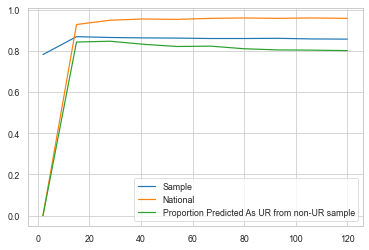

In [ ]:
x_nest= [int(x) for x in np.linspace(2,120,10)]
        
mdl_params = {
#     'n_estimators': 50,
#  'min_samples_split': 100,
#     'min_samples_leaf':8,
#  'max_depth': 34,
 'loss': 'deviance',
#  'learning_rate': learning_rate_gb,
 'criterion': 'friedman_mse',
'random_state':42}
gb_mdl_nest = ensemble.GradientBoostingClassifier
test_scores_x_nest,holdout_natl_x_nest,holdout_natl_ur_x_nest,prop_ur_pred_x_nest = tune_model(gb_mdl_nest,x_nest,'n_estimators',**mdl_params)

In [ ]:
# n_estimators_gb = 1000
n_estimators_gb = 100

**Min Samples Split**

Use 50

2
31
61
91
121
150
180
210
240
270
Test Set Scores:
 Precision: 0.94 
Recall: 0.75 
Accuracy: 0.96 
F1 weighted: 0.96
National Scores:
 Precision: 0.05 
Recall: 0.85 
Accuracy: 0.24 
F1 weighted: 0.33
National UR Scores:
 Precision: 1.0 
Recall: 0.85 
Accuracy: 0.85 
F1 weighted: 0.92


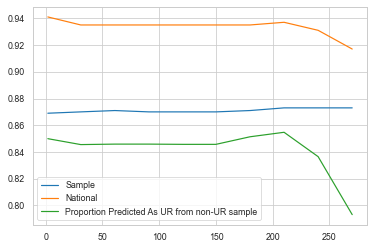

In [ ]:
x_split = [int(x) for x in np.linspace(2,270,10)]
        
mdl_params = {
    'n_estimators': n_estimators_gb,
#  'min_samples_split': 100,
# 'min_samples_leaf':8,
#  'max_depth': 34,
 'loss': 'deviance',
#  'learning_rate': 0.15,
 'criterion': 'friedman_mse',
'random_state':42}
gb_mdl_split = ensemble.GradientBoostingClassifier

test_scores_split,holdout_natl_split,holdout_natl_ur_split,prop_ur_pred_split = tune_model(gb_mdl_split,x_split,'min_samples_split',**mdl_params)

250
341
432
523
614
705
796
887
978
1070
Test Set Scores:
 Precision: 0.83 
Recall: 0.69 
Accuracy: 0.94 
F1 weighted: 0.93
National Scores:
 Precision: 0.08 
Recall: 0.8 
Accuracy: 0.52 
F1 weighted: 0.64
National UR Scores:
 Precision: 1.0 
Recall: 0.8 
Accuracy: 0.8 
F1 weighted: 0.89


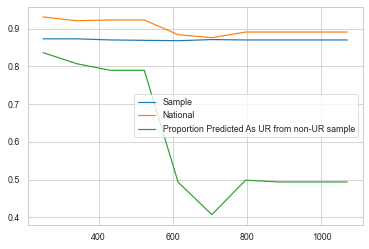

In [ ]:
x_split = [int(x) for x in np.linspace(250,1070,10)]
        
mdl_params = {
    'n_estimators': n_estimators_gb,
#  'min_samples_split': 100,
# 'min_samples_leaf':8,
#  'max_depth': 34,
 'loss': 'deviance',
#  'learning_rate': 0.15,
 'criterion': 'friedman_mse',
'random_state':42}
gb_mdl_split = ensemble.GradientBoostingClassifier

test_scores_split,holdout_natl_split,holdout_natl_ur_split,prop_ur_pred_split = tune_model(gb_mdl_split,x_split,'min_samples_split',**mdl_params)

In [ ]:
min_samples_split_gb = 20

**Tune max depth**

Seems like no need for more than 10. Use 4 or 6, probably 4? 


1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
Test Set Scores:
 Precision: 0.88 
Recall: 0.79 
Accuracy: 0.95 
F1 weighted: 0.95
National Scores:
 Precision: 0.05 
Recall: 0.91 
Accuracy: 0.22 
F1 weighted: 0.3
National UR Scores:
 Precision: 1.0 
Recall: 0.91 
Accuracy: 0.91 
F1 weighted: 0.95


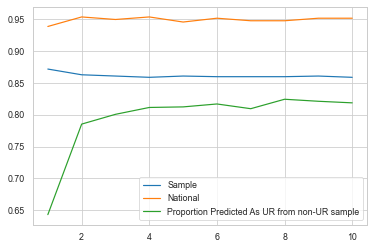

In [ ]:
x_maxdepth= np.linspace(1,10,10)
        
mdl_params = {
    'n_estimators': n_estimators_gb,
 'min_samples_split': min_samples_split_gb,
#     'min_samples_leaf':50,
#  'max_depth': 34,
 'loss': 'deviance',
#  'learning_rate':learning_rate_gb,
 'criterion': 'friedman_mse',
'random_state':42}
gb_mdl_maxdepth = ensemble.GradientBoostingClassifier

test_scores_maxdepth,holdout_natl_maxdepth,holdout_natl_ur_maxdepth,prop_ur_pred_maxdepth = tune_model(gb_mdl_maxdepth,x_maxdepth,'max_depth',**mdl_params)

In [ ]:
max_depth_gb = 6

**Tune min samples leaf**

Seems like anything larger than 77 would be ok. 

10
20
30
40
50
60
70
80
90
100
Test Set Scores:
 Precision: 0.9 
Recall: 0.78 
Accuracy: 0.96 
F1 weighted: 0.96
National Scores:
 Precision: 0.06 
Recall: 0.91 
Accuracy: 0.24 
F1 weighted: 0.33
National UR Scores:
 Precision: 1.0 
Recall: 0.91 
Accuracy: 0.91 
F1 weighted: 0.95


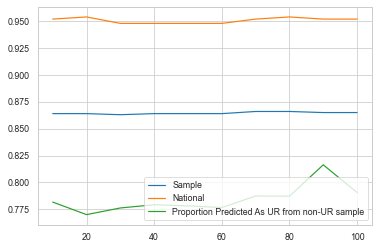

In [ ]:
x_leaf= [int(x) for x in np.linspace(10,100,10)]
        
mdl_params = {
  'n_estimators': n_estimators_gb,
 'min_samples_split': min_samples_split_gb,
#     'min_samples_leaf':50,
 'max_depth': max_depth_gb,
    
 'loss': 'deviance',
#  'learning_rate':learning_rate_gb,
 'criterion': 'friedman_mse',
'random_state':42}
gb_mdl_leaf = ensemble.GradientBoostingClassifier

test_scores_x_leaf,holdout_natl_x_leaf,holdout_natl_ur_x_leaf,prop_ur_pred_x_leaf = tune_model(gb_mdl_leaf,x_leaf,'min_samples_leaf',**mdl_params)




In [ ]:
min_samples_leaf_gb=10

**Tune the learning rate**


Use 0.1 (default) in the future

0.005
0.005555555555555556
0.006111111111111111
0.006666666666666666
0.007222222222222222
0.0077777777777777776
0.008333333333333333
0.008888888888888889
0.009444444444444445
0.01
Test Set Scores:
 Precision: 0.96 
Recall: 0.69 
Accuracy: 0.95 
F1 weighted: 0.95
National Scores:
 Precision: 0.05 
Recall: 0.72 
Accuracy: 0.33 
F1 weighted: 0.45
National UR Scores:
 Precision: 1.0 
Recall: 0.72 
Accuracy: 0.72 
F1 weighted: 0.84


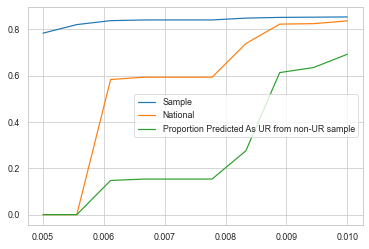

In [ ]:
x_learningrate = np.linspace(.005,.01,10)
        
mdl_params = {
    'n_estimators': n_estimators_gb,
 'min_samples_split': min_samples_split_gb,
    'min_samples_leaf':min_samples_leaf_gb,
 'max_depth': max_depth_gb,
 'loss': 'deviance',
#  'learning_rate': 0.01,
 'criterion': 'friedman_mse',
'random_state':42}
gb_mdl_learningrate = ensemble.GradientBoostingClassifier

test_scores_learningrate,holdout_natl_learningrate,holdout_natl_ur_learningrate,prop_ur_pred_learningrate = tune_model(gb_mdl_learningrate,x_learningrate,'learning_rate',**mdl_params)



In [ ]:
x_learningrate = np.linspace(.001,.005,5)
        
mdl_params = {
    'n_estimators': n_estimators_gb,
 'min_samples_split': min_samples_split_gb,
#     'min_samples_leaf':50,
#  'max_depth': 34,
 'loss': 'deviance',
#  'learning_rate': 0.01,
 'criterion': 'friedman_mse',
'random_state':42}
gb_mdl_learningrate = ensemble.GradientBoostingClassifier

test_scores_learningrate,holdout_natl_learningrate,holdout_natl_ur_learningrate,prop_ur_pred_learningrate = tune_model(gb_mdl_learningrate,x_learningrate,'learning_rate',**mdl_params)



In [ ]:
# learning_rate_gb = 0.0030009
learning_rate_gb = 0.02

Max Features

2
6
10
14
18
23
27
31
35
40
Test Set Scores:
 Precision: 0.92 
Recall: 0.69 
Accuracy: 0.94 
F1 weighted: 0.94
National Scores:
 Precision: 0.06 
Recall: 0.9 
Accuracy: 0.29 
F1 weighted: 0.4
National UR Scores:
 Precision: 1.0 
Recall: 0.9 
Accuracy: 0.9 
F1 weighted: 0.95


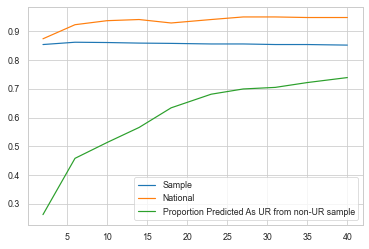

In [ ]:
x_maxfeatures = [int(x) for x in np.linspace(2,40,10)]
        
mdl_params = {
    'n_estimators': n_estimators_gb,
 'min_samples_split': min_samples_split_gb,
    'min_samples_leaf':min_samples_leaf_gb,
 'max_depth': max_depth_gb,
 'loss': 'deviance',
 'learning_rate': learning_rate_gb,
 'criterion': 'friedman_mse',
'random_state':42}
gb_mdl_maxfeatures = ensemble.GradientBoostingClassifier

test_scores_maxfeatures,holdout_natl_maxfeatures,holdout_natl_ur_maxfeatures,prop_ur_pred_maxfeatures = tune_model(gb_mdl_maxfeatures,x_maxfeatures,'max_features',**mdl_params)



In [ ]:
max_features_gb = 2

**Export results**

In [725]:
mdl_params = {
    'n_estimators': n_estimators_gb,
 'min_samples_split': min_samples_split_gb,
    'min_samples_leaf':min_samples_leaf_gb,
 'max_depth': max_depth_gb,
    'max_features':max_features_gb,
 'loss': 'deviance',
 'learning_rate':learning_rate_gb,
#     'learning_rate':.005,
 'criterion': 'friedman_mse',
}

# mdl_params={'n_estimators': 50,
#  'min_samples_split': 20,
#  'min_samples_leaf': 20,
#  'max_depth': 34,
#  'loss': 'deviance',
#  'learning_rate': .015,
#  'criterion': 'friedman_mse'}

gb_mdl_final = ensemble.GradientBoostingClassifier(**mdl_params)
# gb_mdl_final = ensemble.GradientBoostingClassifier()

gb_mdl_final.fit(X_train1,y_train1)

df_all_use4['y_pred'] =gb_mdl_final.predict(X_test1)
print(df_all_use4['y_pred'].sum()/np.sum(y_test1))

# df_rest1_ur['y_prob_1'] = model.predict_proba(X_natl_ur)[:,1]

df_rest1_nonur['y_pred'] =gb_mdl_final.predict(X_natl_nonur)
df_rest1_nonur['y_prob_0'] = gb_mdl_final.predict_proba(X_natl_nonur)[:,0]
df_rest1_nonur['y_prob_1'] = gb_mdl_final.predict_proba(X_natl_nonur)[:,1]
print(df_rest1_nonur['y_pred'].sum()/df_rest1_nonur['y_pred'].shape[0])
update_export_preds(gb_mdl_final,'gb6')

0.6846153846153846
0.3037862703467799
GradientBoostingClassifier(learning_rate=0.02, max_depth=6, max_features=2,
                           min_samples_leaf=10, min_samples_split=20)
Export Done


# 4. Combine models and find average probabilities

In [747]:
X_all = pd.concat([X1_use,X_natl]).sort_index()

In [756]:
rf_pred_1 = rf_mdl_final.predict_proba(X_all)[:,1]
nn_pred_1 = nn_mdl_final.predict_proba(X_all)[:,1]
gb_pred_1 = gb_mdl_final.predict_proba(X_all)[:,1]

In [760]:
df_final = df_all_use3.copy()
df_final['rf_pred_1'] = rf_pred_1
df_final['nn_pred_1'] = nn_pred_1
df_final['gb_pred_1'] = gb_pred_1
df_final['has_ur_bin'] = df_final['has_ur'].apply(lambda x: 0 if x=='no' else 1)
w_rf=1
w_nn=2
w_gb=2

df_final['avg_pred_1'] = df_final[['rf_pred_1','nn_pred_1','gb_pred_1']].apply(lambda x: (w_rf*x['rf_pred_1']+w_nn*x['nn_pred_1']+w_gb*x['gb_pred_1'])/(w_rf+w_nn+w_gb),axis=1)

In [75]:
test = pd.read_sql('select * from ur_tracts_preds_6',con=conn)

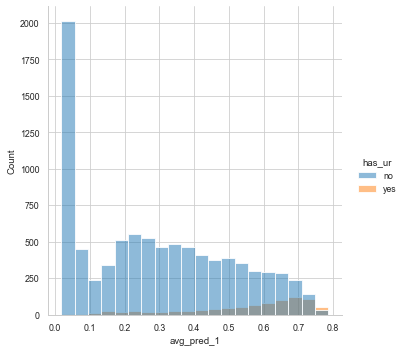

In [761]:
sns.displot(data=df_final,x='avg_pred_1',hue='has_ur')

In [762]:
df_final.merge(
    X_all[X_all.columns[X_all.columns.isin(df_final.columns)==False]],
    left_index=True,
    right_index=True).to_postgis('ur_tracts_preds_6', 
                                 engine, 
                                 if_exists='replace',
                                 index=False, 
                                 dtype={'geom': Geometry(geometry_type='MultiPolygon', srid= 4326)})

# 4.0 Hand Coding? 
What if I just manually coded these tracts? 

There are 64 cities in the analysis


There are only 286 projects missing in the dataset I'd be using.

In [1541]:
ur1_missing = ur1[(ur1.city.isin(df_all_use2_names['NAME'].unique()))&(ur1['Shape_Area'].isna())&\
                      (ur1['project'].str.contains('Interim|Demolition|Demonstration|Dev')==False)]

ur1_missing = ur1_missing.sort_values(['state','city','project'])

In [352]:
ur1_missing.columns

Index(['project_id', 'FID', 'city_id', 'SHAPE_Leng', 'conf', 'Shape_Le_1',
       'Shape_Area', 'geometry', 'area_ur_total', 'amt_reserved_first',
       'amt_reserved_year_first', 'census_year_first', 'project', 'city',
       'state', 'amt_reserved_last', 'amt_reserved_year_last', 'has_geom'],
      dtype='object')

In [354]:
ur1_missing.to_csv('ur1_missing.csv')

In [1542]:
ur1_aggcount = ur1[(ur1['Shape_Area'].isna())&(ur1['project'].str.contains('Interim|Demolition|Demonstration|Dev')==False)]\
                            .groupby(['state','city'])\
                            .count()['project'].sort_values(ascending=False).reset_index()\
                            .rename(columns={'project':'project_count'})

These are the number of projects each city.

In [1545]:
ur1_aggcount.head(10)

,state,city,project_count
0,IL,Chicago,30
1,PA,Philadelphia,20
2,MI,Detroit,13
3,PA,Wilkes Barre,12
4,CT,Hartford,12
5,PA,Scranton,11
6,GA,Savannah,11
7,VA,Portsmouth,11
8,VA,Norfolk,10
9,TN,Memphis,10


In [292]:
ur1[(ur1['city'].str.contains('Pittsburgh'))&(ur1['Shape_Area'].isna())&(ur1['project'].str.contains('Interim|Demolition|Demonstration|Dev')==False)]

,project_id,FID,city_id,SHAPE_Leng,conf,Shape_Le_1,Shape_Area,geometry,amt_reserved_first,amt_reserved_year_first,census_year_first,project,city,state,amt_reserved_last,amt_reserved_year_last,has_geom
1127,1183,NaN,NaN,NaN,NaN,NaN,NaN,None,2797000.0,1960,1960,East Pittsburgh,East Pittsburgh,PA,3917317.0,1974,0
1352,1415,NaN,NaN,NaN,NaN,NaN,NaN,None,7657816.0,1960,1960,East Liberty Sec. A,Pittsburgh,PA,28865649.0,1970,0
1356,1419,NaN,NaN,NaN,NaN,NaN,NaN,None,8424000.0,1970,1970,North Shore,Pittsburgh,PA,8424000.0,1972,0
1362,1427,NaN,NaN,NaN,NaN,NaN,NaN,None,60000.0,1961,1970,Demostration Project,Pittsburgh,PA,57476.0,1970,0
3902,4184,NaN,NaN,NaN,NaN,NaN,NaN,None,18296500.0,1962,1970,Oakland Center,Pittsburgh,PA,18296500.0,1970,0
